## Hi-ChIP analysis plots

In [1]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse

In [2]:
text_size = 8
scaling_factor = 3
plt.rcParams.update({'font.size': 4*scaling_factor, 'axes.linewidth': 0.3*scaling_factor,
                     'xtick.major.size': 1.5*scaling_factor, 'xtick.major.width': 0.3*scaling_factor, 'ytick.major.size': 1.5*scaling_factor, 'ytick.major.width': 0.3*scaling_factor})
# grid letters
grid_letter_positions = [-0.1, 0.05]
grid_letter_fontsize = 8
grid_letter_fontfamily = 'sans-serif'
grid_letter_fontweight = 'bold'
point_size = 1

In [3]:
import matplotlib
def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');
    
def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

### Read results

In [4]:
outdir = "../../results/analysis/HiChIP_data/"
os.listdir(outdir)

['ID2_hg38_hichip_dgd_aligned_locations_rs37.csv',
 'CD69_hg38_hichip_dgd_aligned_locations_rs8790.csv',
 'CLEC16A_hg38_hichip_dgd_aligned_locations_rs0.csv',
 'ID2_hg38_hichip_dgd_aligned_locations_rs0.csv',
 'CLEC16A_hg38_hichip_dgd_aligned_locations_rs37.csv',
 'CLEC16A_hg38_hichip_dgd_aligned_locations_rs8790.csv',
 'CD69_hg38_hichip_dgd_aligned_locations_rs37.csv',
 'CD69_hg38_hichip_dgd_aligned_locations_rs0.csv',
 'ID2_hg38_hichip_dgd_aligned_locations_rs8790.csv']

In [5]:
file_prefix = "_hg38_hichip_dgd_aligned_locations_rs"

In [19]:
# load an example dataset
gene_name = "ID2"
random_seeds = [0, 37, 8790]
for i, rs in enumerate(random_seeds):
    df_dgd_temp = pd.read_csv(outdir + gene_name + file_prefix + str(rs) + ".csv")
    df_dgd_temp["rs"] = rs
    if i == 0:
        dgd_df = df_dgd_temp
    else:
        dgd_df = pd.concat([dgd_df, df_dgd_temp], axis=0)
dgd_df['position'] = (dgd_df.position * 10e5).astype(int)
dgd_df['gene_name'] = gene_name

### functions

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_roc(dgd_df, plot_auroc=False):
    legend_x_dist, legend_y_dist = -0.02, 0.0
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = 5.5,5.5
    matched_ct = dgd_df[dgd_df['cell type'] == 'CD4+ T naive']

    hichip_pos = dgd_df[dgd_df['cell type'] == 'positive'].copy()
    hichip_pos['is_linked_pos'] = hichip_pos.signal > hichip_pos.signal.quantile(0.75)

    hichip_neg = dgd_df[dgd_df['cell type'] == 'negative'].copy()
    hichip_neg['is_linked_neg'] = hichip_neg.signal > hichip_neg.signal.quantile(0.75)

    matched_ct = pd.merge(matched_ct, hichip_neg[['position', 'is_linked_neg']])
    matched_ct = pd.merge(matched_ct, hichip_pos[['position', 'is_linked_pos']])

    # DGD signal on positive
    fpr, tpr, _ =  roc_curve(matched_ct.is_linked_pos, matched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#33a02c',label=f'CD4+T signal - Pos. HiChIP\nAUROC = {np.round(auprc, 3)}')

    # DGD signal on negative
    fpr, tpr, _ =  roc_curve(matched_ct.is_linked_neg, matched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#1f78b4', label=f'CD4+T signal - Neg. HiChIP\nAUROC = {np.round(auprc, 3)}');

    # DGD signal for unmatched cell on positive
    unmatched_ct = dgd_df[dgd_df['cell type'] == 'CD14+ Mono']
    unmatched_ct = pd.merge(unmatched_ct, hichip_pos[['position', 'is_linked_pos']])
    fpr, tpr, _ =  roc_curve(unmatched_ct.is_linked_pos, unmatched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#33a02c', linestyle='--', label=f'CD14+ Mono signal - Pos. HiChIP\nAUROC = {np.round(auprc, 3)}')

    plt.ylabel('TPR'); plt.xlabel("FPR");
    plt.legend(bbox_to_anchor=(1.+legend_x_dist, 1.+legend_y_dist), 
                   loc='upper left', frameon=False,
                   handletextpad=0.1)
    plt.axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':');

### plot roc curves

In [20]:
dgd_df.head()

,position,signal,std,cell type,method,rs,gene_name
0,7189869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD,0,ID2
1,7199869,3.553820e-07,2.130216e-07,CD8+ T,multiDGD,0,ID2
2,7209869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD,0,ID2
3,7219869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD,0,ID2
4,7229869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD,0,ID2


In [22]:
matched_ct = dgd_df[dgd_df['cell type'] == 'CD4+ T naive']

hichip_pos = dgd_df[dgd_df['cell type'] == 'positive'].copy()
hichip_pos['is_linked_pos'] = hichip_pos.signal > hichip_pos.signal.quantile(0.75)

hichip_neg = dgd_df[dgd_df['cell type'] == 'negative'].copy()
hichip_neg['is_linked_neg'] = hichip_neg.signal > hichip_neg.signal.quantile(0.75)

matched_ct = pd.merge(matched_ct, hichip_neg[['position', 'is_linked_neg']])
matched_ct = pd.merge(matched_ct, hichip_pos[['position', 'is_linked_pos']])
auroc_df = pd.DataFrame(columns = ['cell_type', 'HiChIP_track', 'AUROC', 'method', 'gene', 'rs'])

In [33]:
random_seeds = [0, 37, 8790]
auroc_df = pd.DataFrame()
for gene in ['CD69', 'CLEC16A', 'ID2']:
    for i, rs in enumerate(random_seeds):
        dgd_df = pd.read_csv(outdir + gene + file_prefix + str(rs) + ".csv")
        dgd_df['position'] = (dgd_df.position * 10e5).astype(int)
        dgd_df['gene_name'] = gene
    
        # multiDGD results
        df = dgd_df.copy()
        matched_ct = df[df['cell type'] == 'CD4+ T naive']
        hichip_pos = df[df['cell type'] == 'positive'].copy()
        hichip_pos['is_linked_pos'] = hichip_pos.signal > hichip_pos.signal.quantile(0.75)

        hichip_neg = df[df['cell type'] == 'negative'].copy()
        hichip_neg['is_linked_neg'] = hichip_neg.signal > hichip_neg.signal.quantile(0.75)

        matched_ct = pd.merge(matched_ct, hichip_neg[['position', 'is_linked_neg']])
        matched_ct = pd.merge(matched_ct, hichip_pos[['position', 'is_linked_pos']])

        fpr, tpr, _ =  roc_curve(matched_ct.is_linked_pos, matched_ct.signal)
        auroc = auc(fpr, tpr)
        auroc_df = pd.concat([auroc_df, pd.DataFrame(['matched', 'Pos HiChIP', auroc, 'multiDGD', gene, rs]).T])
        fpr, tpr, _ =  roc_curve(matched_ct.is_linked_neg, matched_ct.signal)
        auroc = auc(fpr, tpr)
        auroc_df = pd.concat([auroc_df, pd.DataFrame(['matched', 'Neg HiChIP', auroc, 'multiDGD', gene, rs]).T])

        unmatched_ct = dgd_df[dgd_df['cell type'] == 'CD14+ Mono']
        unmatched_ct = pd.merge(unmatched_ct, hichip_pos[['position', 'is_linked_pos']])
        fpr, tpr, _ =  roc_curve(unmatched_ct.is_linked_pos, unmatched_ct.signal)
        auroc = auc(fpr, tpr)
        auroc_df = pd.concat([auroc_df, pd.DataFrame(['unmatched', 'Pos HiChIP', auroc, 'multiDGD', gene, rs]).T])
# set column names
auroc_df.columns = ['cell_type', 'HiChIP_track', 'AUROC', 'method', 'gene', 'rs']
auroc_df['class'] = auroc_df.cell_type + ' - '+ auroc_df.HiChIP_track

In [31]:
auroc_df

,cell_type,HiChIP_track,AUROC,method,gene,rs,class
0,matched,Pos HiChIP,0.711826,multiDGD,CD69,0,matched - Pos HiChIP
0,matched,Neg HiChIP,0.646036,multiDGD,CD69,0,matched - Neg HiChIP
0,unmatched,Pos HiChIP,0.604138,multiDGD,CD69,0,unmatched - Pos HiChIP
0,matched,Pos HiChIP,0.732186,multiDGD,CD69,37,matched - Pos HiChIP
0,matched,Neg HiChIP,0.664535,multiDGD,CD69,37,matched - Neg HiChIP
0,unmatched,Pos HiChIP,0.591986,multiDGD,CD69,37,unmatched - Pos HiChIP
0,matched,Pos HiChIP,0.708234,multiDGD,CD69,8790,matched - Pos HiChIP
0,matched,Neg HiChIP,0.624471,multiDGD,CD69,8790,matched - Neg HiChIP
0,unmatched,Pos HiChIP,0.604138,multiDGD,CD69,8790,unmatched - Pos HiChIP
0,matched,Pos HiChIP,0.711826,multiDGD,CLEC16A,0,matched - Pos HiChIP


In [40]:
pointplot_scale = 0.5
pointplot_errwidth = 2.0
pointplot_capsize = 0.05

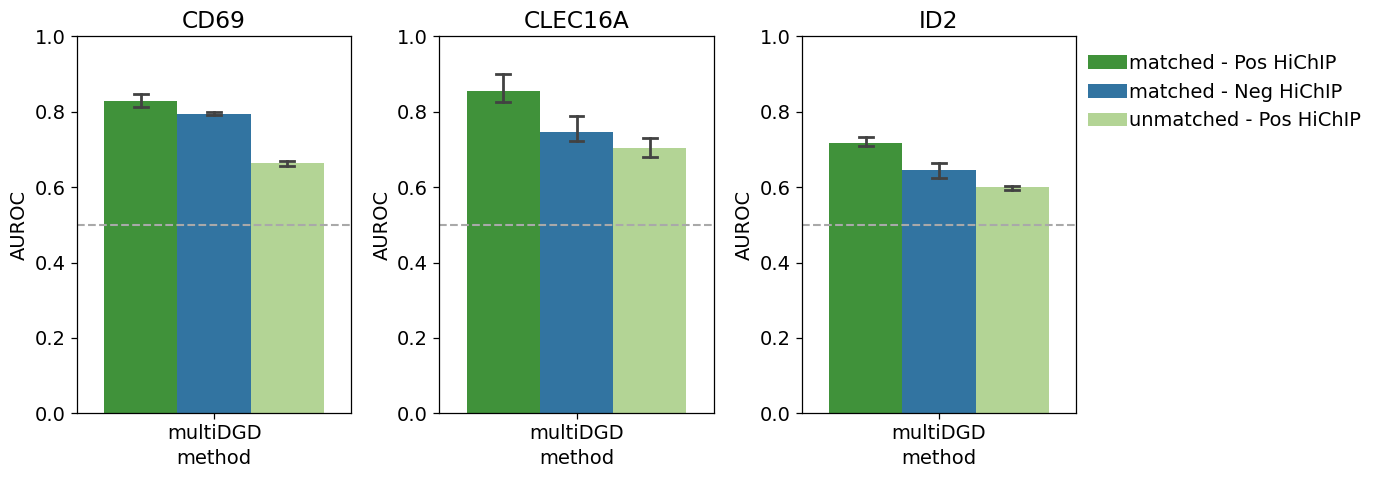

In [41]:
plt.rcParams['figure.figsize'] = [14,5]
plt.rcParams['font.size'] = 14
for i,gene in enumerate(['CD69', 'CLEC16A', 'ID2']):
    plt.subplot(1,3,i+1);
    legend_x_dist, legend_y_dist = -0.02, 0.0

    palette_auroc = {
        'matched - Pos HiChIP':'#33a02c',
        'matched - Neg HiChIP':'#1f78b4',
        'unmatched - Pos HiChIP':'#b2df8a',
    }
    sns.barplot(data=auroc_df[auroc_df.gene == gene], x='method', y='AUROC', hue='class', palette=palette_auroc, capsize=pointplot_capsize, errwidth=pointplot_errwidth);
    if i == 2:
        plt.legend(bbox_to_anchor=(1.+legend_x_dist, 1.+legend_y_dist), 
                           loc='upper left', frameon=False,
                           handletextpad=0.1);
    else:
        plt.legend([], frameon=False)
    plt.title(gene);
    plt.axhline(0.5,  color='darkgrey', linestyle='--')
    plt.ylim(0,1)
plt.tight_layout()
plt.show()